**Τεχνικές Εξόρυξης Δεδομένων εργασία 2**

Συντελεστές:


*   Κυριακόπουλος Βασίλειος 1115201700064
*   Κουτσάκης Δημήτριος 1115201700061

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Εισαγωγή απαραίτητων βιβλιοθηκών:**

In [2]:
import pandas as pd
import string
import re
import numpy as np
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score, classification_report
from gensim.models import Word2Vec
import matplotlib.pyplot as plt

%matplotlib inline

**Φόρτωση δεδομένων:**

In [3]:
# Load true news from file
true_news = pd.read_csv('/content/gdrive/MyDrive/Data Mining/datasets/True.csv')
# Remove rows with empty fields
true_news.replace(" ",float("NaN"),inplace=True)
true_news.dropna(inplace=True)
true_news

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


In [4]:
# Load fake news from file
fake_news = pd.read_csv('/content/gdrive/MyDrive/Data Mining/datasets/Fake.csv')
# Remove rows with empty fields
fake_news.replace(" ",float("NaN"),inplace=True)
fake_news.dropna(inplace=True)
fake_news

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


**Προεπεξεργασία/καθάρισμα:**

In [5]:
def text_preprocessing(text):
    # Remove hashtags
    text = re.sub(r'#\w+',' ',text)
    # Remove tags
    text = re.sub(r'@\w+',' ',text)
    # Remove urls
    text = re.sub(r'https?://\S+',' ',text)
    # Remove special characters
    text = re.sub(r'\W',' ',text)
    # Remove single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ',text)
    # Remove single characters from start
    text = re.sub(r'^[a-zA-Z]\s+', ' ',text)
    # Remove numbers
    text = re.sub(r'\d+',' ',text)
    # Convert multiple spaces to single space and remove beginning and end spaces
    text = re.sub(r' +',' ',text).strip()
    # Convert to lowercase
    text = text.lower()

    return text

In [6]:
true_news['title'] = true_news['title'].apply(lambda row : text_preprocessing(row))
true_news['text'] = true_news['text'].apply(lambda row : text_preprocessing(row))
true_news.replace("",float("NaN"),inplace=True)
true_news.dropna(inplace=True)

fake_news['title'] = fake_news['title'].apply(lambda row : text_preprocessing(row))
fake_news['text'] = fake_news['text'].apply(lambda row : text_preprocessing(row))
fake_news.replace("",float("NaN"),inplace=True)
fake_news.dropna(inplace=True)

In [7]:
true_news

,title,text,subject,date
0,as s budget fight looms republicans flip their...,washington reuters the head of conservative re...,politicsNews,"December 31, 2017"
1,military to accept transgender recruits on mon...,washington reuters transgender people will be ...,politicsNews,"December 29, 2017"
2,senior s republican senator let mr mueller do ...,washington reuters the special counsel investi...,politicsNews,"December 31, 2017"
3,fbi russia probe helped by australian diplomat...,washington reuters trump campaign adviser geor...,politicsNews,"December 30, 2017"
4,trump wants postal service to charge much more...,seattle washington reuters president donald tr...,politicsNews,"December 29, 2017"
...,...,...,...,...
21412,fully committed nato backs new s approach on a...,brussels reuters nato allies on tuesday welcom...,worldnews,"August 22, 2017"
21413,lexisnexis withdrew two products from chinese ...,london reuters lexisnexis provider of legal re...,worldnews,"August 22, 2017"
21414,minsk cultural hub becomes haven from authorities,minsk reuters in the shadow of disused soviet ...,worldnews,"August 22, 2017"
21415,vatican upbeat on possibility of pope francis ...,moscow reuters vatican secretary of state card...,worldnews,"August 22, 2017"


In [8]:
fake_news

,title,text,subject,date
0,donald trump sends out embarrassing new year e...,donald trump just couldn wish all americans ha...,News,"December 31, 2017"
1,drunk bragging trump staffer started russian c...,house intelligence committee chairman devin nu...,News,"December 31, 2017"
2,sheriff david clarke becomes an internet joke ...,on friday it was revealed that former milwauke...,News,"December 30, 2017"
3,trump is so obsessed he even has obama name co...,on christmas day donald trump announced that h...,News,"December 29, 2017"
4,pope francis just called out donald trump duri...,pope francis used his annual christmas day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,mcpain john mccain furious that iran treated u...,st century wire says as wire reported earlier ...,Middle-east,"January 16, 2016"
23477,justice yahoo settles mail privacy class actio...,st century wire says it a familiar theme whene...,Middle-east,"January 16, 2016"
23478,sunnistan us and allied safe zone plan to take...,patrick henningsen st century wireremember whe...,Middle-east,"January 15, 2016"
23479,how to blow million al jazeera america finally...,st century wire says al jazeera america will g...,Middle-east,"January 14, 2016"


**Μελέτη των δεδομένων:**

**α.** Ο τίτλος καθορίζει αρκετά το περιεχόμενο ενός άρθρου. Προσπαθήστε να
οπτικοποιήστε τους τίτλους των fake και των non-fake news έτσι ώστε να μπορεί
κάποιος να εντοπίσει τα κεντρικά θέματα τα οποία διαπραγματεύονται τα άρθρα.


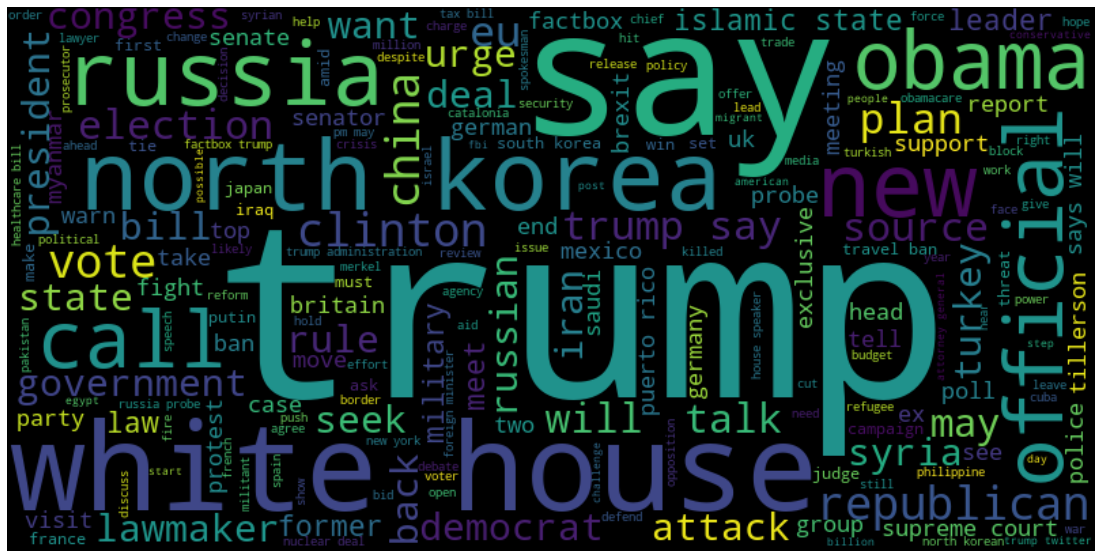

In [9]:
true_news_wordcloud = WordCloud(width=800,height=400).generate(' '.join(true_news['title']))
plt.figure(figsize=(20,10))
plt.imshow(true_news_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

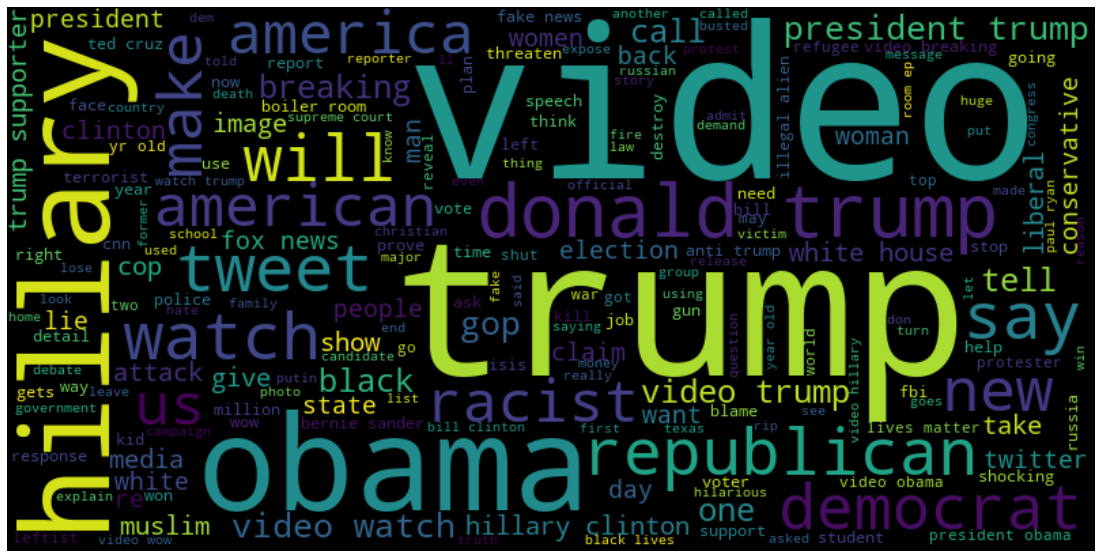

In [10]:
fake_news_wordcloud = WordCloud(width=800,height=400).generate(' '.join(fake_news['title']))
plt.figure(figsize=(20,10))
plt.imshow(fake_news_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**β.** Σχεδιάστε γραφήματα που να δείχνουν το μέσο όρο των χαρακτήρων στα fake και
στα true news αντίστοιχα. Κάντε το ίδιο και για τη στήλη text.


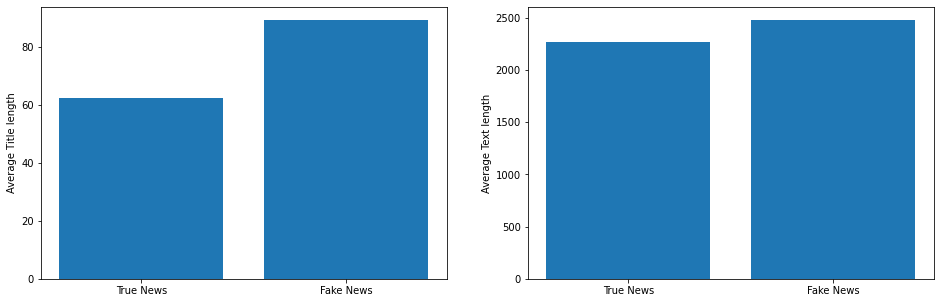

In [11]:
true_title_len = true_news['title'].apply(len).mean()
true_text_len = true_news['text'].apply(len).mean()

fake_title_len = fake_news['title'].apply(len).mean()
fake_text_len = fake_news['text'].apply(len).mean()

fig = plt.figure(figsize=(16,5))
title = ['True News', 'Fake News']
ax = plt.subplot(1,2,1)
avg = [true_title_len, fake_title_len]
ax.bar(title,avg)
plt.ylabel('Average Title length')
ax = plt.subplot(1,2,2)
avg = [true_text_len, fake_text_len]
ax.bar(title,avg)
plt.ylabel('Average Text length')
plt.show()

**γ.** Σχεδιάστε την κατανομή του αριθμού των λέξεων για τη στήλη title και για τη στήλη
text (και για τα δύο αρχεία)


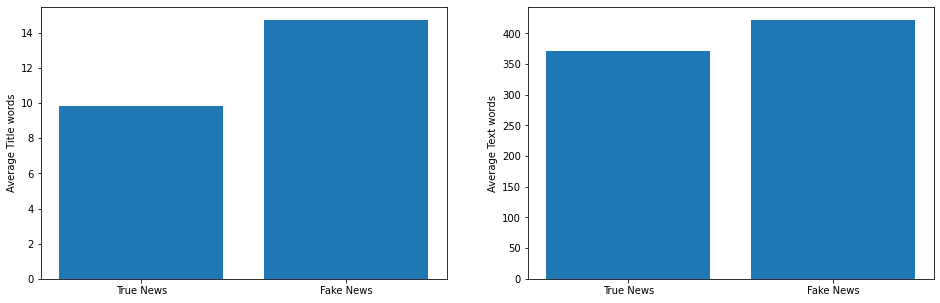

In [12]:
true_title_words = true_news['title'].str.split().apply(len).mean()
true_text_words = true_news['text'].str.split().apply(len).mean()

fake_title_words = fake_news['title'].str.split().apply(len).mean()
fake_text_words = fake_news['text'].str.split().apply(len).mean()

fig = plt.figure(figsize=(16,5))
title = ['True News', 'Fake News']
ax = plt.subplot(1,2,1)
avg = [true_title_words, fake_title_words]
ax.bar(title,avg)
plt.ylabel('Average Title words')
ax = plt.subplot(1,2,2)
avg = [true_text_words, fake_text_words]
ax.bar(title,avg)
plt.ylabel('Average Text words')
plt.show()

**δ.** Επαναλλάβετε το προηγούμενο ερώτημα αφαιρώντας τα stopwords.

In [13]:
def remove_stopwords(text):
  return ' '.join([word for word in text.split() if word not in STOPWORDS])

In [14]:
true_news_nostop = true_news
true_news_nostop['title'] = true_news_nostop['title'].apply(remove_stopwords)
true_news_nostop['text'] = true_news_nostop['text'].apply(remove_stopwords)
true_news_nostop = true_news_nostop.dropna()

fake_news_nostop = fake_news
fake_news_nostop['title'] = fake_news_nostop['title'].apply(remove_stopwords)
fake_news_nostop['text'] = fake_news_nostop['text'].apply(remove_stopwords)
fake_news_nostop = fake_news_nostop.dropna()

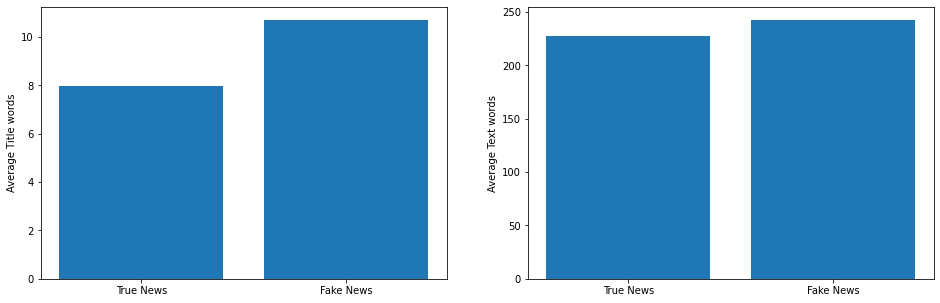

In [15]:
true_title_words = true_news_nostop['title'].str.split().apply(len).mean()
true_text_words = true_news_nostop['text'].str.split().apply(len).mean()

fake_title_words = fake_news_nostop['title'].str.split().apply(len).mean()
fake_text_words = fake_news_nostop['text'].str.split().apply(len).mean()

fig = plt.figure(figsize=(16,5))
title = ['True News', 'Fake News']
ax = plt.subplot(1,2,1)
avg = [true_title_words, fake_title_words]
ax.bar(title,avg)
plt.ylabel('Average Title words')
ax = plt.subplot(1,2,2)
avg = [true_text_words, fake_text_words]
ax.bar(title,avg)
plt.ylabel('Average Text words')
plt.show()

**ε.** Ποιά είναι τα πιο συχνά (πχ 10 ή 20) bigrams στους τίτλους και ποιά στο κυρίως άρθρο;


In [16]:
def count_bigrams(df,col):
  bigrams_freq = dict()
  for val in df[col].values:
    words = val.split()
    for i in range(len(words)-1):
      bigram = words[i] + '_' + words[i+1]
      if bigram in bigrams_freq:
        bigrams_freq[bigram]+=1
      else:
        bigrams_freq[bigram] = 1
  return bigrams_freq

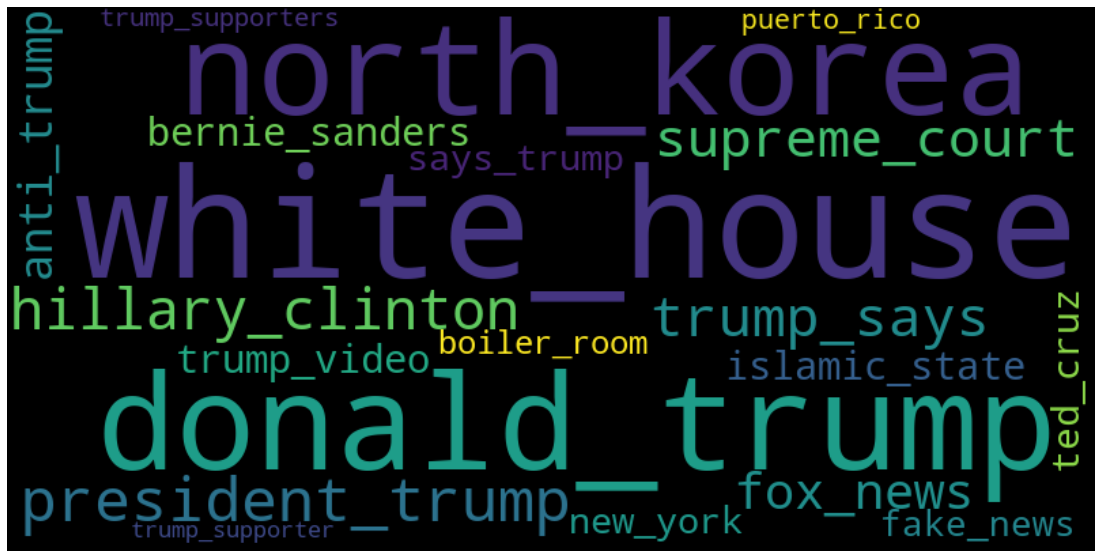

In [17]:
df = pd.concat([true_news_nostop, fake_news_nostop])
title_bigram_frequencies = count_bigrams(df,'title')
title_bigrams_wordcloud = WordCloud(max_words=20,width=800,height=400).generate_from_frequencies(title_bigram_frequencies)
plt.figure(figsize=(20,10))
plt.imshow(title_bigrams_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

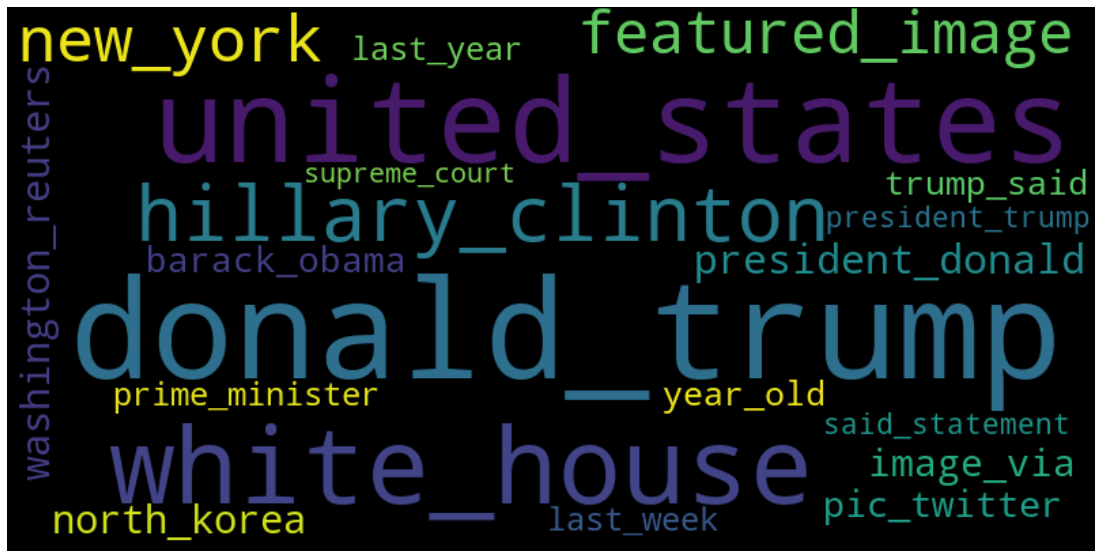

In [18]:
text_bigram_frequencies = count_bigrams(df,'text')
text_bigrams_wordcloud = WordCloud(max_words=20,width=800,height=400).generate_from_frequencies(text_bigram_frequencies)
plt.figure(figsize=(20,10))
plt.imshow(text_bigrams_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Δημιουργία συνόλου εκμάθησης και δοκιμής:**

In [19]:
# Add labels to true and fake news
true_news_nostop['label'] = 1
fake_news_nostop['label'] = 0
# Concatenate them 
news = pd.concat([true_news_nostop, fake_news_nostop])
# Split them in train and test sets
train_news, test_news = train_test_split(news,test_size=0.2,random_state=42)
# Save them
train_news = train_news.reset_index().drop(columns=['index'])
train_news.to_csv('train.csv',index=False)
test_news = test_news.reset_index().drop(columns=['index'])
test_news.to_csv('test.csv',index=False)

**Υλοποίηση Κατηγοριοποίησης (Classification):**

Φόρτωση train και test data:

In [20]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Δημιουργία BoW αναπαραστάσεων για τα text των train και test set:

In [21]:
countVectorizer = CountVectorizer(min_df=3,max_df=0.6)
train_text_bow = countVectorizer.fit_transform(train['text'].values.astype('U'))
test_text_bow = countVectorizer.transform(test['text'].values.astype('U'))
print(train_text_bow.shape,test_text_bow.shape)

(35346, 45211) (8837, 45211)


Δημιουργία tf-idf αναπαραστάσεων για τα text των train και test set:

In [22]:
tfidfVectorizer = TfidfVectorizer(min_df=20,max_df=1.0)
train_text_tfidf = tfidfVectorizer.fit_transform(train['text'].values.astype('U'))
test_text_tfidf = tfidfVectorizer.transform(test['text'].values.astype('U'))
print(train_text_tfidf.shape,test_text_tfidf.shape)

(35346, 18007) (8837, 18007)


Εκπαίδευση word2vec μοντέλου:

In [23]:
tokens = [text.lower().split() for text in train['text'].values] + [text.lower().split() for text in test['text'].values]
w2vmodel = Word2Vec(tokens,size=100,seed=32,negative=5,sg=0,min_count=1,window=5)
w2vmodel.train(tokens, total_examples=w2vmodel.corpus_count, epochs=10,report_delay=1)

(101425031, 104001840)

Αναπαράσταση των train και test texts σε διάνυσμα μέσω των embeddings:

In [24]:
def text_embedding(text,embeddings):
  tokens = text.lower().split()
  emb = np.zeros((embeddings.vector_size,))
  cnt = 0
  for token in tokens:
    if token in embeddings:
      emb+=embeddings[token]
      cnt+=1
  if cnt > 0:
    emb /= cnt
  return emb 

In [25]:
train_text_embeddings = np.array([text_embedding(text,w2vmodel.wv) for text in train['text'].values])

In [26]:
test_text_embeddings = np.array([text_embedding(text,w2vmodel.wv) for text in test['text'].values])

**Logistic Regression with BoW:**

In [27]:
logReg = LogisticRegression(random_state=0,max_iter=1000)
X_train = train_text_bow
y_train = train['label'].values
X_test = test_text_bow
y_test = test['label'].values
logReg.fit(X_train,y_train)
y_true = y_test
y_pred = logReg.predict(X_test)
accuracy = accuracy_score(y_true,y_pred)
f1Score = f1_score(y_true,y_pred)
print(classification_report(y_true,y_pred,target_names=['True','Fake']))
print("Accuracy:",accuracy)
print("F1-Score:",f1Score)

              precision    recall  f1-score   support

        True       1.00      1.00      1.00      4516
        Fake       1.00      1.00      1.00      4321

    accuracy                           1.00      8837
   macro avg       1.00      1.00      1.00      8837
weighted avg       1.00      1.00      1.00      8837

Accuracy: 0.997170985628607
F1-Score: 0.9971088238695501


**Logistic Regression with tf-idf:**

In [28]:
logReg = LogisticRegression(random_state=0,max_iter=1000)
X_train = train_text_tfidf
y_train = train['label'].values
X_test = test_text_tfidf
y_test = test['label'].values
logReg.fit(X_train,y_train)
y_true = y_test
y_pred = logReg.predict(X_test)
accuracy = accuracy_score(y_true,y_pred)
f1Score = f1_score(y_true,y_pred)
print(classification_report(y_true,y_pred,target_names=['True','Fake']))
print("Accuracy:",accuracy)
print("F1-Score:",f1Score)

              precision    recall  f1-score   support

        True       0.99      0.98      0.99      4516
        Fake       0.98      0.99      0.99      4321

    accuracy                           0.99      8837
   macro avg       0.99      0.99      0.99      8837
weighted avg       0.99      0.99      0.99      8837

Accuracy: 0.9877786579155822
F1-Score: 0.987554736114312


**Logistic Regression with word2vec vectors:**

In [29]:
logReg = LogisticRegression(random_state=0,max_iter=1000)
X_train = train_text_embeddings
y_train = train['label'].values
X_test = test_text_embeddings
y_test = test['label'].values
logReg.fit(X_train,y_train)
y_true = y_test
y_pred = logReg.predict(X_test)
accuracy = accuracy_score(y_true,y_pred)
f1Score = f1_score(y_true,y_pred)
print(classification_report(y_true,y_pred,target_names=['True','Fake']))
print("Accuracy:",accuracy)
print("F1-Score:",f1Score)

              precision    recall  f1-score   support

        True       0.97      0.97      0.97      4516
        Fake       0.97      0.97      0.97      4321

    accuracy                           0.97      8837
   macro avg       0.97      0.97      0.97      8837
weighted avg       0.97      0.97      0.97      8837

Accuracy: 0.9703519293878012
F1-Score: 0.9697738809413936


**Naive Bayes with BoW:**

In [30]:
nb = MultinomialNB()
X_train = train_text_bow
y_train = train['label'].values
X_test = test_text_bow
y_test = test['label'].values
nb.fit(X_train,y_train)
y_true = y_test
y_pred = nb.predict(X_test)
accuracy = accuracy_score(y_true,y_pred)
f1Score = f1_score(y_true,y_pred)
print(classification_report(y_true,y_pred,target_names=['True','Fake']))
print("Accuracy:",accuracy)
print("F1-Score:",f1Score)

              precision    recall  f1-score   support

        True       0.95      0.95      0.95      4516
        Fake       0.95      0.94      0.95      4321

    accuracy                           0.95      8837
   macro avg       0.95      0.95      0.95      8837
weighted avg       0.95      0.95      0.95      8837

Accuracy: 0.949417223039493
F1-Score: 0.9480896527697132


**Naive Bayes with tf-idf:**

In [31]:
nb = MultinomialNB()
X_train = train_text_tfidf
y_train = train['label'].values
X_test = test_text_tfidf
y_test = test['label'].values
nb.fit(X_train,y_train)
y_true = y_test
y_pred = nb.predict(X_test)
accuracy = accuracy_score(y_true,y_pred)
f1Score = f1_score(y_true,y_pred)
print(classification_report(y_true,y_pred,target_names=['True','Fake']))
print("Accuracy:",accuracy)
print("F1-Score:",f1Score)

              precision    recall  f1-score   support

        True       0.94      0.94      0.94      4516
        Fake       0.94      0.93      0.94      4321

    accuracy                           0.94      8837
   macro avg       0.94      0.94      0.94      8837
weighted avg       0.94      0.94      0.94      8837

Accuracy: 0.9371958809550752
F1-Score: 0.9356969064998263


**Naive Bayes with word2vec vectors:**

In [32]:
nb = GaussianNB()
X_train = train_text_embeddings
y_train = train['label'].values
X_test = test_text_embeddings
y_test = test['label'].values
nb.fit(X_train,y_train)
y_true = y_test
y_pred = nb.predict(X_test)
accuracy = accuracy_score(y_true,y_pred)
f1Score = f1_score(y_true,y_pred)
print(classification_report(y_true,y_pred,target_names=['True','Fake']))
print("Accuracy:",accuracy)
print("F1-Score:",f1Score)

              precision    recall  f1-score   support

        True       0.91      0.90      0.91      4516
        Fake       0.90      0.91      0.91      4321

    accuracy                           0.91      8837
   macro avg       0.91      0.91      0.91      8837
weighted avg       0.91      0.91      0.91      8837

Accuracy: 0.9078872920674437
F1-Score: 0.9063506672802577


**Linear SVM with BoW:**

In [33]:
clf = LinearSVC(C=2.7,dual=False)
X_train = train_text_bow
y_train = train['label'].values
X_test = test_text_bow
y_test = test['label'].values
clf.fit(X_train,y_train)
y_true = y_test
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_true,y_pred)
f1Score = f1_score(y_true,y_pred)
print(classification_report(y_true,y_pred,target_names=['True','Fake']))
print("Accuracy:",accuracy)
print("F1-Score:",f1Score)

              precision    recall  f1-score   support

        True       1.00      1.00      1.00      4516
        Fake       1.00      1.00      1.00      4321

    accuracy                           1.00      8837
   macro avg       1.00      1.00      1.00      8837
weighted avg       1.00      1.00      1.00      8837

Accuracy: 0.9969446644788955
F1-Score: 0.9968768074031231


**Linear SVM with tf-idf:**

In [34]:
clf = LinearSVC(C=2.0,dual=False)
X_train = train_text_tfidf
y_train = train['label'].values
X_test = test_text_tfidf
y_test = test['label'].values
clf.fit(X_train,y_train)
y_true = y_test
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_true,y_pred)
f1Score = f1_score(y_true,y_pred)
print(classification_report(y_true,y_pred,target_names=['True','Fake']))
print("Accuracy:",accuracy)
print("F1-Score:",f1Score)

              precision    recall  f1-score   support

        True       1.00      0.99      0.99      4516
        Fake       0.99      1.00      0.99      4321

    accuracy                           0.99      8837
   macro avg       0.99      0.99      0.99      8837
weighted avg       0.99      0.99      0.99      8837

Accuracy: 0.994341971257214
F1-Score: 0.9942209893666205


**Linear SVM with word2vec:**

In [37]:
clf = LinearSVC(C=2.0,dual=False)
X_train = train_text_embeddings
y_train = train['label'].values
X_test = test_text_embeddings
y_test = test['label'].values
clf.fit(X_train,y_train)
y_true = y_test
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_true,y_pred)
f1Score = f1_score(y_true,y_pred)
print(classification_report(y_true,y_pred,target_names=['True','Fake']))
print("Accuracy:",accuracy)
print("F1-Score:",f1Score)

              precision    recall  f1-score   support

        True       0.97      0.97      0.97      4516
        Fake       0.97      0.97      0.97      4321

    accuracy                           0.97      8837
   macro avg       0.97      0.97      0.97      8837
weighted avg       0.97      0.97      0.97      8837

Accuracy: 0.9701256082380898
F1-Score: 0.9695290858725762


**RBF SVM with BoW:**

In [41]:
clf = SVC(kernel='rbf',C=1.0,gamma='scale')
X_train = train_text_bow
y_train = train['label'].values
X_test = test_text_bow
y_test = test['label'].values
clf.fit(X_train,y_train)
y_true = y_test
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_true,y_pred)
f1Score = f1_score(y_true,y_pred)
print(classification_report(y_true,y_pred,target_names=['True','Fake']))
print("Accuracy:",accuracy)
print("F1-Score:",f1Score)

              precision    recall  f1-score   support

        True       0.99      0.99      0.99      4516
        Fake       0.99      0.99      0.99      4321

    accuracy                           0.99      8837
   macro avg       0.99      0.99      0.99      8837
weighted avg       0.99      0.99      0.99      8837

Accuracy: 0.9929840443589454
F1-Score: 0.9928157589803013


**RBF SVM with tf-idf:**

In [42]:
clf = SVC(kernel='rbf',C=1.0,gamma='scale')
X_train = train_text_tfidf
y_train = train['label'].values
X_test = test_text_tfidf
y_test = test['label'].values
clf.fit(X_train,y_train)
y_true = y_test
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_true,y_pred)
f1Score = f1_score(y_true,y_pred)
print(classification_report(y_true,y_pred,target_names=['True','Fake']))
print("Accuracy:",accuracy)
print("F1-Score:",f1Score)

              precision    recall  f1-score   support

        True       0.99      0.99      0.99      4516
        Fake       0.99      0.99      0.99      4321

    accuracy                           0.99      8837
   macro avg       0.99      0.99      0.99      8837
weighted avg       0.99      0.99      0.99      8837

Accuracy: 0.9927577232092339
F1-Score: 0.9926079926079925


**RBF SVM with word2vec:**

In [43]:
clf = SVC(kernel='rbf',C=1.0,gamma='scale')
X_train = train_text_embeddings
y_train = train['label'].values
X_test = test_text_embeddings
y_test = test['label'].values
clf.fit(X_train,y_train)
y_true = y_test
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_true,y_pred)
f1Score = f1_score(y_true,y_pred)
print(classification_report(y_true,y_pred,target_names=['True','Fake']))
print("Accuracy:",accuracy)
print("F1-Score:",f1Score)

              precision    recall  f1-score   support

        True       0.99      0.98      0.98      4516
        Fake       0.98      0.98      0.98      4321

    accuracy                           0.98      8837
   macro avg       0.98      0.98      0.98      8837
weighted avg       0.98      0.98      0.98      8837

Accuracy: 0.980989023424239
F1-Score: 0.9806362378976486


**Random Forest with BoW:**

In [38]:
rf = RandomForestClassifier()
X_train = train_text_bow
y_train = train['label'].values
X_test = test_text_bow
y_test = test['label'].values
rf.fit(X_train,y_train)
y_true = y_test
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_true,y_pred)
f1Score = f1_score(y_true,y_pred)
print(classification_report(y_true,y_pred,target_names=['True','Fake']))
print("Accuracy:",accuracy)
print("F1-Score:",f1Score)

              precision    recall  f1-score   support

        True       0.99      0.99      0.99      4516
        Fake       0.99      0.99      0.99      4321

    accuracy                           0.99      8837
   macro avg       0.99      0.99      0.99      8837
weighted avg       0.99      0.99      0.99      8837

Accuracy: 0.9941156501075026
F1-Score: 0.9939856581077955


**Random Forest with tf-Idf:**

In [39]:
rf = RandomForestClassifier()
X_train = train_text_tfidf
y_train = train['label'].values
X_test = test_text_tfidf
y_test = test['label'].values
rf.fit(X_train,y_train)
y_true = y_test
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_true,y_pred)
f1Score = f1_score(y_true,y_pred)
print(classification_report(y_true,y_pred,target_names=['True','Fake']))
print("Accuracy:",accuracy)
print("F1-Score:",f1Score)

              precision    recall  f1-score   support

        True       1.00      1.00      1.00      4516
        Fake       1.00      1.00      1.00      4321

    accuracy                           1.00      8837
   macro avg       1.00      1.00      1.00      8837
weighted avg       1.00      1.00      1.00      8837

Accuracy: 0.9981894308023085
F1-Score: 0.9981490050902361


**Random Forest with word2vec:**

In [40]:
rf = RandomForestClassifier()
X_train = train_text_embeddings
y_train = train['label'].values
X_test = test_text_embeddings
y_test = test['label'].values
rf.fit(X_train,y_train)
y_true = y_test
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_true,y_pred)
f1Score = f1_score(y_true,y_pred)
print(classification_report(y_true,y_pred,target_names=['True','Fake']))
print("Accuracy:",accuracy)
print("F1-Score:",f1Score)

              precision    recall  f1-score   support

        True       0.97      0.97      0.97      4516
        Fake       0.97      0.97      0.97      4321

    accuracy                           0.97      8837
   macro avg       0.97      0.97      0.97      8837
weighted avg       0.97      0.97      0.97      8837

Accuracy: 0.9708045716872241
F1-Score: 0.9700696055684456


Παρατηρούμε ότι από τους παραπάνω αλγόριθμους, ο Naive Bayes έχει τα μικρότερα accuracy και f1 scores. Αυτό, λογικά οφείλεται στο γεγονός ότι υποθέτει πως τα features είναι ανεξάρτητα μεταξύ τους κάτι που δεν ισχύει πάντα και οι άλλοι πιο αυστηροι αλγόριθμοι δεν ασχολούνται με την ανεξαρτησία των δεδομένων. Αυτός είναι και ο λόγος που οι άλλοι αλγόριθμοι δουλεύουν καλύτερα, δεν κάνουν δηλαδή τέτοιες προσεγγιστικές υποθέσεις και λαμβάνουν πιο αυστηρά μέτρα εγγύτητας.

Παρατηρούμε επίσης ότι οι ακρίβειες στα word2vec representations είναι μικρότερες από τις αντίστοιχες για τα bow και tf-idf representations. Αυτό πιθανόν να οφείλεται στο γεγονός ότι το word2vec είναι φτιαγμένο αποκλειστικά και μόνο για διανυσματική αναπαράσταση λέξεων και όχι κειμένων, το οποίο σημαίνει ότι η προσέγγιση με τον υπολοισμό του median των word2vec vectors του αντίστοιχου κειμένου για την αναπαράστασή του σε διάνυσμα πιθανότατα να μην δουλεύει πολύ καλά, ενώ οι άλλες 2 αναπαραστάσεις λαμβάνουν υπ οψιν κι άλλα χαρακτηριστικά. Επίσης παίζει ρόλο και η διάσταση που είναι συνήθως πολύ μικρότερη στα word2vec vectors.